In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from sklearn import neighbors, svm
from sklearn.compose import make_column_transformer

import utils
import statistics

import importlib
importlib.reload(utils)

<module 'utils' from '/Users/clement/OneDrive/School/ML/assignment1/utils.py'>

# Dataset

(25000, 518)

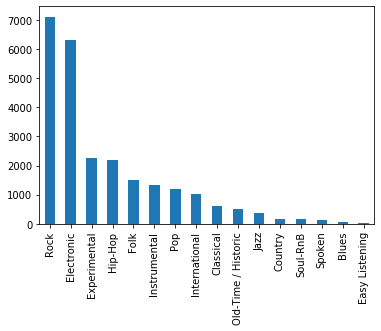

In [2]:
# Load metadata and features.
tracks = utils.load('datasets/fma_metadata/tracks.csv')
genres = utils.load('datasets/fma_metadata/genres.csv')
features_csv = utils.load('datasets/fma_metadata/features.csv')
echonest = utils.load('datasets/fma_metadata/echonest.csv')

subset = tracks['set', 'subset'] <= 'medium'
features = features_csv.loc[subset]
target = tracks.loc[subset, ('track', 'genre_top')]
target.value_counts().plot(kind="bar")

features.shape

In [3]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
134           0.918445  0.674147  0.577818  1.281117  0.933746  0.078177   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
134         1.199204 -0.175223  0.925482  1.438509  ...  0.058766  0.016322   

feature                     zcr                                               \
statistics             kurtosis       max      mean    median  min      skew   
number            06         01        01        01        01   01        01   
track_id                                                                       
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.0  2.089872   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.0  1.716724   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.0  2.193303   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.0  3.542325   
134         0.015819   4.731087  0.419434  0.064370  0.050781  0.0  1.806106   

feature               
statistics       std  
number            01  
track_id              
2           0.061448  
3           0.069330  
5           0.044861  
10          0.040800  
134         0.054623  

[5 rows x 518 columns]

In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k_best = SelectKBest(mutual_info_classif, k=150).fit(features, target)
for importance, name in sorted(zip(k_best.scores_, features.columns),reverse=True):
    print (name, importance)

('mfcc', 'median', '01') 0.21848291056101177
('mfcc', 'median', '03') 0.20489932460735538
('mfcc', 'mean', '01') 0.20248200459195997
('spectral_rolloff', 'median', '01') 0.2013917258806055
('mfcc', 'max', '01') 0.20066854033244308
('spectral_contrast', 'mean', '04') 0.19979476556878817
('mfcc', 'max', '04') 0.19962713714670066
('spectral_contrast', 'median', '02') 0.19673419781483226
('spectral_bandwidth', 'median', '01') 0.1967332154143544
('mfcc', 'mean', '03') 0.1964702781322294
('spectral_contrast', 'mean', '02') 0.19434768495003896
('spectral_rolloff', 'kurtosis', '01') 0.19209911562033843
('spectral_rolloff', 'mean', '01') 0.1919414791355578
('spectral_contrast', 'median', '04') 0.19188231926988442
('spectral_contrast', 'median', '03') 0.19013178540974396
('spectral_contrast', 'mean', '03') 0.18783746475387808
('mfcc', 'median', '04') 0.18370048667909433
('spectral_centroid', 'std', '01') 0.18259882765303814
('spectral_bandwidth', 'mean', '01') 0.18223223409246136
('spectral_roll

In [4]:
# Grab subset of features
# k_features = k_best.transform(features)

features = features_csv.loc[subset, ['mfcc', 'spectral_rolloff', 'spectral_contrast']]

print(features.shape)

(25000, 196)


In [5]:
# Split train/test data and scale features
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=28)

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(x_train.shape[1], np.unique(y_train).size))

# Scale train and test data if estimator requires it
scaler = StandardScaler()
scaler.fit(x_train)

scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
unique_elements, counts_elements = np.unique(y_test, return_counts=True)

20000 training examples, 5000 testing examples
196 features, 16 classes


# Baseline

In [9]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(x_train, y_train)
pred = dummy_clf.predict(x_test)
print(classification_report(y_test, pred))

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
pred = dummy_clf.predict(x_test)
print(classification_report(y_test, pred, digits=4))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61      4673
           1       0.22      0.49      0.30      1327

    accuracy                           0.50      6000
   macro avg       0.50      0.50      0.46      6000
weighted avg       0.65      0.50      0.54      6000

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000



/home/clement/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

In [12]:
decision_tree_cf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy')
scores = cross_val_score(decision_tree_cf, x_train, y_train, cv=5, scoring='f1_macro')
print(statistics.mean(scores))

0.28700501723725813


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed:   18.6s remaining:  3.8min
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed:   43.9s remaining:  3.4min
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed:  1.1min remaining:  2.8min
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed:  1.5min remaining:  2.4min
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed:  1.9min remaining:  2.0min
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed:  2.4min remaining:  1.6min
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed:  2.7min remaining:  1.2min
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed:  3.1min remaining:   47.0s
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed:  3.5min remaining:   22.7s
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed:  3.9min finished


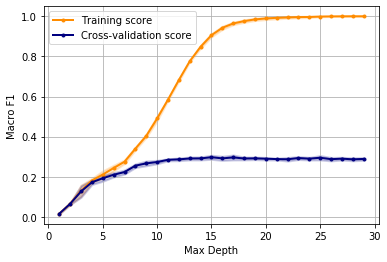

In [13]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(decision_tree_cf, x_train, y_train, param_name="max_depth", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Max Depth")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 out of 500 | elapsed:  1.5min remaining: 16.4min
[Parallel(n_jobs=8)]: Done  93 out of 500 | elapsed:  3.1min remaining: 13.4min
[Parallel(n_jobs=8)]: Done 144 out of 500 | elapsed:  4.6min remaining: 11.5min
[Parallel(n_jobs=8)]: Done 195 out of 500 | elapsed:  6.5min remaining: 10.2min
[Parallel(n_jobs=8)]: Done 246 out of 500 | elapsed:  8.1min remaining:  8.4min
[Parallel(n_jobs=8)]: Done 297 out of 500 | elapsed: 10.0min remaining:  6.8min
[Parallel(n_jobs=8)]: Done 348 out of 500 | elapsed: 11.7min remaining:  5.1min
[Parallel(n_jobs=8)]: Done 399 out of 500 | elapsed: 13.4min remaining:  3.4min
[Parallel(n_jobs=8)]: Done 450 out of 500 | elapsed: 15.2min remaining:  1.7min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 16.8min finished


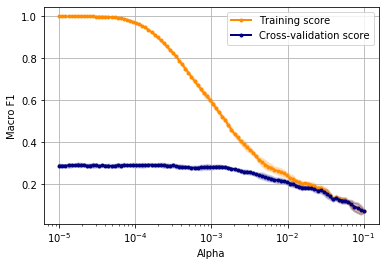

In [17]:
param_range = np.geomspace(0.00001, 0.1, 100, endpoint=True)
train_scores, test_scores = validation_curve(decision_tree_cf, x_train, y_train, param_name="ccp_alpha", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Alpha", log=True)

In [77]:
params = [{'ccp_alpha': np.linspace(0.0005, 0.002, 20, endpoint=True), 'max_depth': range(1, 8)}]
grid_cv = GridSearchCV(decision_tree_cf, params, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
grid_cv.fit(x_train, y_train)
res = grid_cv.cv_results_

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(

In [78]:
decision_tree_cf = grid_cv.best_estimator_
print (grid_cv.best_score_, grid_cv.best_params_)

0.6902299616673246 {'ccp_alpha': 0.0007368421052631579, 'max_depth': 4}


In [56]:
decision_tree_cf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', ccp_alpha=0.01, max_depth=7)

[learning_curve] Training set sizes: [ 1600  5200  8800 12400 16000]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:    8.6s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:   14.6s remaining:   58.3s
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:   18.8s remaining:   40.0s
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:   23.9s remaining:   30.4s
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:   27.3s remaining:   21.5s
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:   32.0s remaining:   15.1s
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:   37.3s remaining:    9.3s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:   54.8s remaining:    4.8s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.2min finished


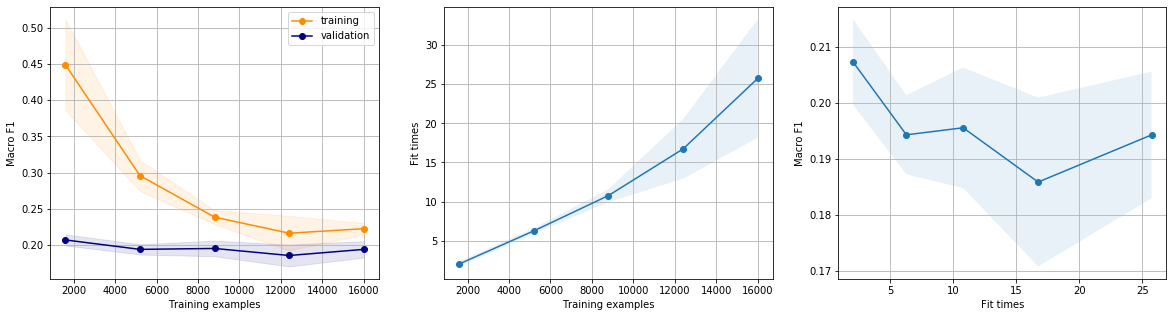

In [57]:
title = ''
utils.plot_learning_curve(decision_tree_cf, title, x_train, y_train, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [58]:
decision_tree_cf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [59]:
tree_pred = decision_tree_cf.predict(x_test)
print(confusion_matrix(y_test, tree_pred))
print(classification_report(y_test, tree_pred, digits=4))

[[  2   2   0   0   0   5   1   1   0   2   1   0   0   0   0   1]
 [  2  90   2   1   0   6   1   0   0   0  21   0   0   0   0   1]
 [  2   0  10   1   0   0   8   3   1   1   2   0   0   5   2   0]
 [  1   0   0   0   0   0   0   1   0   0   1   0   0   0   1   0]
 [ 71  51  38  27 112 150  42 238  37  35  75   1   0  59 261  66]
 [ 33  74  24   7  18 107  13  35  13  10  27   6   0  23  25  35]
 [ 17  26  34   2   2   9 113  12  19   9  34   1   0   5   2  19]
 [ 32   2  18  27  21  14  10 143   3   7   9   0   0  21 118  15]
 [ 15  77   5   5   3  27  11  21  19   5  46   3   0   8   3  22]
 [ 18  12  32   6   0  16  17  24  10  17   8   2   0   3  18  21]
 [  7  19   3   0   1   2   5   3   4   3  22   1   0   3   2   2]
 [  0   9   0   0   0   5   0   0   0   0   0  86   0   0   0   2]
 [ 13   5  29   5   3  13  37  37  10  10  16   2   0  20  20  17]
 [168  30 132   8  80  66  88 182  85  33  26   0   0 407  85  31]
 [  5   0   3   1   0   0   1   2   0   2   4   0   0   2  10 

/home/clement/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
for importance, name in sorted(zip(decision_tree_cf.feature_importances_, features.columns),reverse=True):
    print (name, importance)

('mfcc', 'max', '04') 0.23204166186814082
('mfcc', 'mean', '01') 0.09619982729660896
('mfcc', 'max', '03') 0.0814551174249213
('mfcc', 'std', '06') 0.0686963402609376
('spectral_contrast', 'mean', '04') 0.05793366864993043
('spectral_contrast', 'median', '03') 0.04494980568777186
('mfcc', 'median', '17') 0.04173013888847497
('mfcc', 'min', '10') 0.03912689750678872
('mfcc', 'std', '04') 0.027617075725123306
('mfcc', 'skew', '08') 0.022690603097076673
('spectral_contrast', 'std', '03') 0.021379738071192294
('mfcc', 'median', '02') 0.020299719669040508
('mfcc', 'mean', '08') 0.019686671667346244
('mfcc', 'mean', '03') 0.0184565764456896
('mfcc', 'max', '14') 0.018426274649837524
('spectral_contrast', 'mean', '06') 0.016621304631989395
('mfcc', 'mean', '02') 0.015632000380279502
('mfcc', 'median', '19') 0.013579278396464852
('mfcc', 'min', '05') 0.013538747691943583
('mfcc', 'median', '10') 0.012897974751057889
('mfcc', 'median', '14') 0.011212683134470568
('mfcc', 'median', '01') 0.01084

/home/clement/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


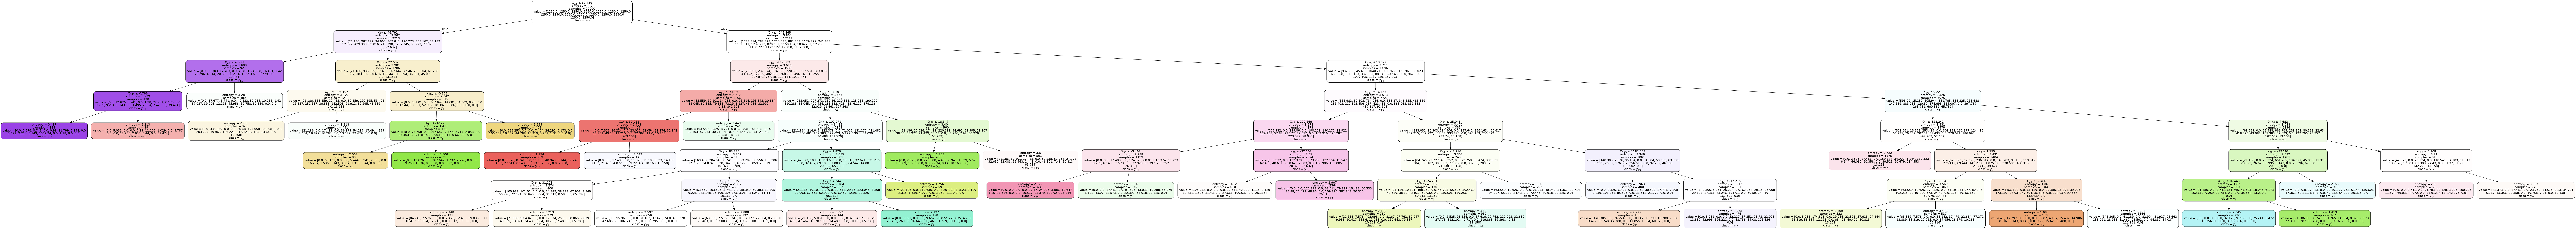

In [61]:
# Decision Tree visualizer code credit to this SO post:
# https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(decision_tree_cf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

# Neural Network

In [8]:
nn_clf = MLPClassifier(early_stopping=True)
scores = cross_val_score(nn_clf, scaled_x_train, y_train, cv=5, n_jobs=1, scoring='f1_macro')
print(statistics.mean(scores))

0.4461531686466425


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of 100 | elapsed:   16.9s remaining: 13.8min
[Parallel(n_jobs=8)]: Done  13 out of 100 | elapsed:   29.6s remaining:  3.3min
[Parallel(n_jobs=8)]: Done  24 out of 100 | elapsed:   47.3s remaining:  2.5min
[Parallel(n_jobs=8)]: Done  35 out of 100 | elapsed:   58.6s remaining:  1.8min
[Parallel(n_jobs=8)]: Done  46 out of 100 | elapsed:  1.4min remaining:  1.7min
[Parallel(n_jobs=8)]: Done  57 out of 100 | elapsed:  1.6min remaining:  1.2min
[Parallel(n_jobs=8)]: Done  68 out of 100 | elapsed:  2.0min remaining:   56.0s
[Parallel(n_jobs=8)]: Done  79 out of 100 | elapsed:  2.2min remaining:   34.5s
[Parallel(n_jobs=8)]: Done  90 out of 100 | elapsed:  2.6min remaining:   17.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.7min finished


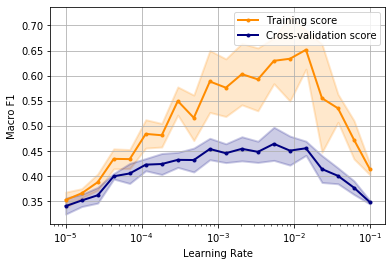

In [30]:
param_range = np.geomspace(0.00001, 0.1, 20, endpoint=True)
# param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1]
train_scores, test_scores = validation_curve(nn_clf, scaled_x_train, y_train, param_name="learning_rate_init", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Learning Rate", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  35 | elapsed:    9.3s remaining:  1.2min
[Parallel(n_jobs=8)]: Done   8 out of  35 | elapsed:   13.9s remaining:   46.9s
[Parallel(n_jobs=8)]: Done  12 out of  35 | elapsed:   22.0s remaining:   42.2s
[Parallel(n_jobs=8)]: Done  16 out of  35 | elapsed:   30.4s remaining:   36.1s
[Parallel(n_jobs=8)]: Done  20 out of  35 | elapsed:   34.3s remaining:   25.7s
[Parallel(n_jobs=8)]: Done  24 out of  35 | elapsed:   37.6s remaining:   17.2s
[Parallel(n_jobs=8)]: Done  28 out of  35 | elapsed:   44.2s remaining:   11.1s
[Parallel(n_jobs=8)]: Done  32 out of  35 | elapsed:   51.6s remaining:    4.8s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:   59.5s finished


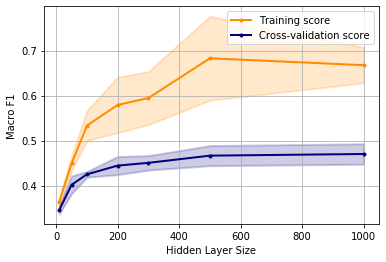

In [8]:
param_range = [(10), (50), (100), (200), (300), (500), (1000)]
train_scores, test_scores = validation_curve(nn_clf, scaled_x_train, y_train, param_name="hidden_layer_sizes", 
    param_range=param_range, scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Hidden Layer Size")

/Users/clement/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  after removing the cwd from sys.path.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:   16.8s remaining:  1.8min
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:   18.2s remaining:   50.0s
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   24.9s remaining:   37.4s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:   32.4s remaining:   28.4s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:   33.9s remaining:   17.0s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   38.5s remaining:    9.6s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   44.5s finished


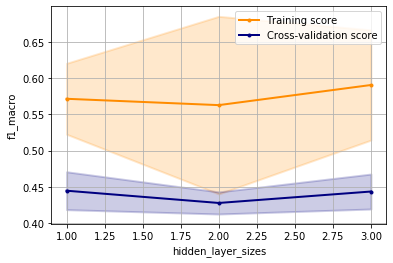

In [11]:
import importlib
importlib.reload(utils)
param_range = [(128), (128, 128), (128, 128, 128)]
train_scores, test_scores = validation_curve(nn_clf, scaled_x_train, y_train.values.ravel(), param_name="hidden_layer_sizes", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.xlabel('hidden_layer_sizes')
plt.ylabel('f1_macro')
lw = 2
param_range = [1,2,3]
plt.plot(param_range, train_scores_mean, '.-', label="Training score",
            color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
            color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  30 | elapsed:    7.4s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   7 out of  30 | elapsed:   19.2s remaining:  1.1min
[Parallel(n_jobs=8)]: Done  11 out of  30 | elapsed:   24.9s remaining:   43.1s
[Parallel(n_jobs=8)]: Done  15 out of  30 | elapsed:   38.3s remaining:   38.3s
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed:   44.2s remaining:   25.6s
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed:   57.0s remaining:   17.3s
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed:  1.0min remaining:    6.9s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  1.1min finished


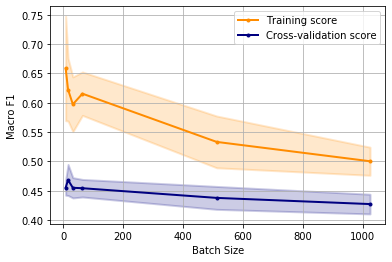

In [39]:
import importlib
importlib.reload(utils)
param_range = [8, 16, 32, 64, 512, 1024]
train_scores, test_scores = validation_curve(nn_clf, scaled_x_train, y_train, param_name="batch_size", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Batch Size")

In [9]:
tuned_parameters = [{'batch_size': [16, 32, 64, 128, 256, 512, 1024], 'solver': ['adam'], 
                     'hidden_layer_sizes': [(128), (128, 128), (128, 128, 128)], 
                     'learning_rate_init': [0.00008, 0.0001, 0.0003],
                     'alpha': [0.0001, 0.001, 0.01, 0.1]}]
                     
nn_grid_cv = GridSearchCV(nn_clf, tuned_parameters, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
nn_grid_cv.fit(scaled_x_train, y_train)
nn_res = nn_grid_cv.cv_results_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   48.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  8.1min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 10.3min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 13.5min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 14.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 15.5min
[Parallel(

In [10]:
nn_clf = nn_grid_cv.best_estimator_
print (nn_grid_cv.best_score_, nn_grid_cv.best_params_)

0.45904210473661633 {'alpha': 0.01, 'batch_size': 16, 'hidden_layer_sizes': 128, 'learning_rate_init': 0.0003, 'solver': 'adam'}


In [50]:
nn_clf = MLPClassifier(early_stopping=True, alpha=0.01, batch_size=16, hidden_layer_sizes=128, learning_rate_init=0.0003)

[learning_curve] Training set sizes: [ 1600  5200  8800 12400 16000]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:   10.7s remaining:  2.1min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:   28.5s remaining:  1.9min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:   38.2s remaining:  1.4min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:   57.0s remaining:  1.2min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  1.0min remaining:   47.4s
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:  1.1min remaining:   31.2s
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:  1.4min remaining:   21.6s
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  1.5min remaining:    8.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  2.1min finished


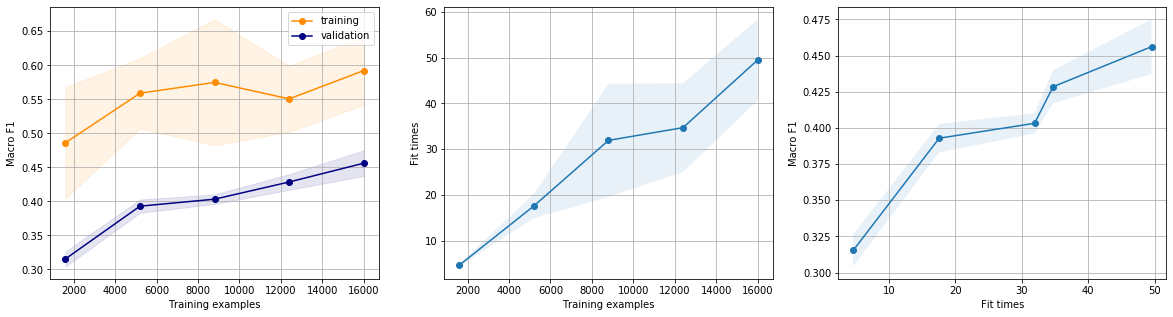

In [54]:
title = ''
utils.plot_learning_curve(nn_clf, title, scaled_x_train, y_train, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [51]:
nn_clf.fit(scaled_x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=16, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=128, learning_rate='constant',
              learning_rate_init=0.0003, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

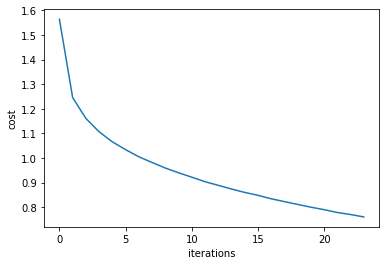

In [52]:
plt.ylabel('cost')
plt.xlabel('iterations')
plt.plot(nn_clf.loss_curve_)
plt.show()

In [53]:
nn_pred = nn_clf.predict(scaled_x_test)
print(confusion_matrix(y_test, nn_pred))
print(classification_report(y_test, nn_pred, digits=4))

[[   0    0    0    0    2    3    1    0    0    1    2    0    0    6
     0    0]
 [   0   97    0    0    2    8    3    0    8    1    3    0    0    2
     0    0]
 [   0    0    7    0    0    1    8    1    1    1    0    0    2   14
     0    0]
 [   0    0    0    0    2    2    0    0    0    0    0    0    0    0
     0    0]
 [   0    8    0    0  959   59    6   63   39   16    5    0   15   93
     0    0]
 [   0   13    0    0   78  214   16   13   26    5    5    1    4   73
     0    2]
 [   0    4    1    0   10   15  189    5   11   14    2    1    9   43
     0    0]
 [   0    0    0    0  109    9    3  280    4    5    0    0    8   21
     0    1]
 [   0   12    0    0   55   47    9    3   93    2    3    1    6   39
     0    0]
 [   0    1    0    0   32   14   14   16    4   99    3    0    2   19
     0    0]
 [   0    8    0    0    9    6    3    0   10    3   22    0    2   14
     0    0]
 [   0    0    0    0    1    4    0    0    0    1    0   94    

/home/clement/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN

In [63]:
knn_clf = neighbors.KNeighborsClassifier(n_jobs=8)
scores = cross_val_score(knn_clf, scaled_x_train, y_train, cv=5, scoring='f1_macro')
print(statistics.mean(scores))

0.4651537451839618


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed: 10.6min remaining: 129.4min
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed: 17.3min remaining: 79.1min
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed: 27.7min remaining: 70.2min
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed: 37.4min remaining: 59.4min
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed: 47.2min remaining: 49.2min
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed: 57.3min remaining: 39.3min
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed: 67.4min remaining: 29.4min
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed: 74.7min remaining: 18.7min
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed: 84.7min remaining:  9.1min
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed: 94.0min finished


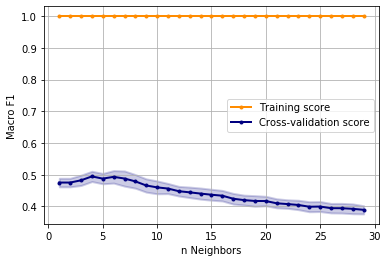

In [64]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(neighbors.KNeighborsClassifier(weights='distance'), scaled_x_train, y_train, param_name="n_neighbors", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "n Neighbors")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  11 out of 145 | elapsed: 10.5min remaining: 127.4min
[Parallel(n_jobs=8)]: Done  26 out of 145 | elapsed: 17.2min remaining: 78.7min
[Parallel(n_jobs=8)]: Done  41 out of 145 | elapsed: 27.6min remaining: 70.0min
[Parallel(n_jobs=8)]: Done  56 out of 145 | elapsed: 37.5min remaining: 59.7min
[Parallel(n_jobs=8)]: Done  71 out of 145 | elapsed: 48.2min remaining: 50.2min
[Parallel(n_jobs=8)]: Done  86 out of 145 | elapsed: 58.0min remaining: 39.8min
[Parallel(n_jobs=8)]: Done 101 out of 145 | elapsed: 68.8min remaining: 30.0min
[Parallel(n_jobs=8)]: Done 116 out of 145 | elapsed: 75.7min remaining: 18.9min
[Parallel(n_jobs=8)]: Done 131 out of 145 | elapsed: 86.3min remaining:  9.2min
[Parallel(n_jobs=8)]: Done 145 out of 145 | elapsed: 96.5min finished


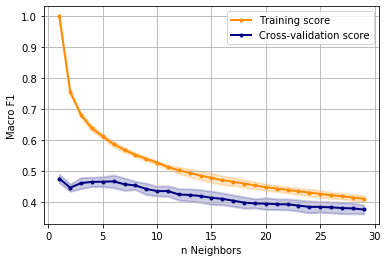

In [65]:
param_range = range(1, 30)
train_scores, test_scores = validation_curve(neighbors.KNeighborsClassifier(weights='uniform'), scaled_x_train, y_train, param_name="n_neighbors", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "n Neighbors")

In [66]:
# Credit to sklearn tutorial on KNN classification:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
tuned_parameters = [{'n_neighbors': range(10, 30), 'weights': ['uniform'], 'p': [1, 2]}]
                     
knn_grid_cv = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
knn_grid_cv.fit(scaled_x_train, y_train)
knn_res = knn_grid_cv.cv_results_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 10.9min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 20.9min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 26.1min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 31.8min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 37.1min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 47.5min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 56.7min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 66.2min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 73.9min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 86.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 97.9min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 110.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 121.2min
[Paralle

In [67]:
knn_clf = knn_grid_cv.best_estimator_
print (knn_grid_cv.best_score_, knn_grid_cv.best_params_)

0.4531627462779205 {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}


[learning_curve] Training set sizes: [ 1600  5200  8800 12400 16000]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:    9.4s remaining:  1.8min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:   53.0s remaining:  3.5min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:  1.8min remaining:  3.9min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:  2.6min remaining:  3.3min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  3.3min remaining:  2.6min
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:  4.5min remaining:  2.1min
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed:  5.6min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  7.1min remaining:   37.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  9.5min finished


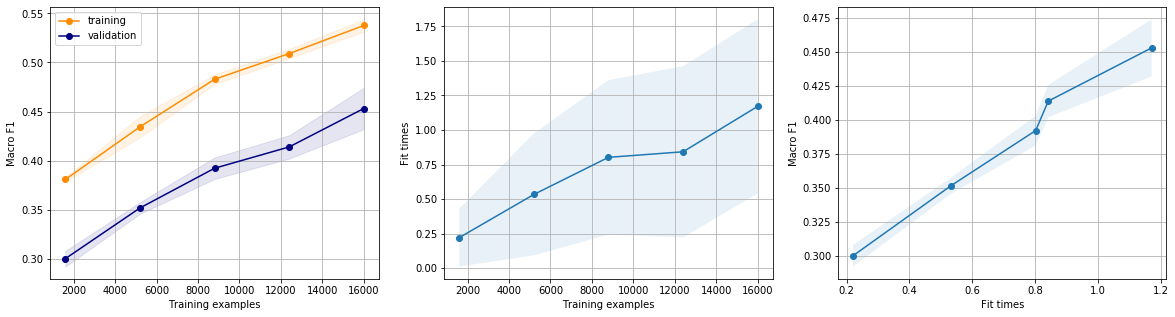

In [68]:
title = ''
utils.plot_learning_curve(knn_clf, title, scaled_x_train, y_train, n_jobs=8, scoring='f1_macro', loss=False)
plt.show()

In [69]:
knn_pred = knn_clf.predict(scaled_x_test)
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred, digits=4))

[[   3    0    0    0    5    0    2    1    1    0    2    0    0    1
     0    0]
 [   0  102    0    0    1    2    6    1    4    1    2    0    0    5
     0    0]
 [   0    0   16    0    0    0    7    1    1    2    0    0    0    8
     0    0]
 [   0    0    1    0    1    0    0    1    0    0    0    0    0    1
     0    0]
 [   0   14    3    0  878   11   27  109   35   21    4    1    8  152
     0    0]
 [   0   18    2    0  119   71   25   28   35   18    7    0    8  119
     0    0]
 [   0    9    4    0    7    2  210    5   11   13    2    0    3   38
     0    0]
 [   1    0    1    0   98    1    4  292    0    9    0    0    3   31
     0    0]
 [   0   34    0    0   49   12   19    6   77    8    5    1    4   55
     0    0]
 [   0    1    2    0   23    0   17   20    2  122    1    0    2   14
     0    0]
 [   0   14    2    0    9    3    6    2    6    3   19    0    1   12
     0    0]
 [   0    0    0    0    0    1    0    0    1    0    0  100    

/home/clement/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM

In [70]:
svm_clf = svm.SVC(class_weight='balanced')
scores = cross_val_score(svm_clf, scaled_x_train, y_train, cv=5, scoring='f1_macro', n_jobs=8)
print(statistics.mean(scores))

0.5174520570606026


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  50 | elapsed:  6.1min remaining: 95.0min
[Parallel(n_jobs=8)]: Done   9 out of  50 | elapsed: 15.5min remaining: 70.8min
[Parallel(n_jobs=8)]: Done  15 out of  50 | elapsed: 21.8min remaining: 50.9min
[Parallel(n_jobs=8)]: Done  21 out of  50 | elapsed: 30.7min remaining: 42.4min
[Parallel(n_jobs=8)]: Done  27 out of  50 | elapsed: 336.9min remaining: 287.0min
[Parallel(n_jobs=8)]: Done  33 out of  50 | elapsed: 344.0min remaining: 177.2min
[Parallel(n_jobs=8)]: Done  39 out of  50 | elapsed: 349.4min remaining: 98.5min
[Parallel(n_jobs=8)]: Done  45 out of  50 | elapsed: 358.7min remaining: 39.9min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 362.7min finished


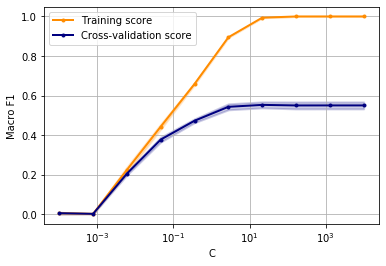

In [71]:
param_range = np.geomspace(10**-4, 10**4, 10)
train_scores, test_scores = validation_curve(svm_clf, scaled_x_train, y_train, param_name="C", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "C", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  50 | elapsed: 10.3min remaining: 161.3min
[Parallel(n_jobs=8)]: Done   9 out of  50 | elapsed: 20.8min remaining: 94.6min
[Parallel(n_jobs=8)]: Done  15 out of  50 | elapsed: 31.9min remaining: 74.4min
[Parallel(n_jobs=8)]: Done  21 out of  50 | elapsed: 39.0min remaining: 53.9min
[Parallel(n_jobs=8)]: Done  27 out of  50 | elapsed: 52.3min remaining: 44.5min
[Parallel(n_jobs=8)]: Done  33 out of  50 | elapsed: 56.6min remaining: 29.1min
[Parallel(n_jobs=8)]: Done  39 out of  50 | elapsed: 69.5min remaining: 19.6min
[Parallel(n_jobs=8)]: Done  45 out of  50 | elapsed: 83.6min remaining:  9.3min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 88.6min finished


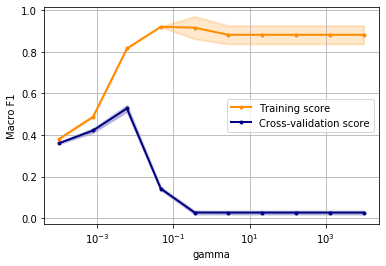

In [72]:
param_range = np.geomspace(10**-4, 10**4, 10)
train_scores, test_scores = validation_curve(svm_clf, scaled_x_train, y_train, param_name="gamma", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "gamma", log=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  20 | elapsed:  8.9min remaining: 50.2min
[Parallel(n_jobs=8)]: Done   6 out of  20 | elapsed:  9.5min remaining: 22.2min
[Parallel(n_jobs=8)]: Done   9 out of  20 | elapsed: 13.9min remaining: 17.0min
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed: 18.1min remaining: 12.0min
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed: 19.9min remaining:  6.6min
[Parallel(n_jobs=8)]: Done  18 out of  20 | elapsed: 23.4min remaining:  2.6min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed: 28.5min finished


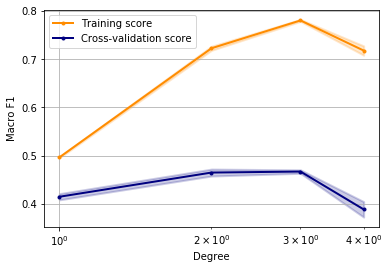

In [73]:
param_range = [1,2,3,4]
train_scores, test_scores = validation_curve(svm.SVC(class_weight='balanced', kernel='poly'), scaled_x_train, y_train, param_name="degree", param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "Degree", log=True)

In [75]:
# Credit to sklearn svm tuturial: 
# https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
tuned_parameters = [{'kernel': ['rbf'], 'gamma': np.geomspace(0.001, 0.01, 5), 'C': np.geomspace(0.01, 0.5, 5)}]
                     
svm_grid_cv = GridSearchCV(svm.SVC(class_weight='balanced'), tuned_parameters, cv=3, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
svm_grid_cv.fit(scaled_x_train, y_train)
svm_res = svm_grid_cv.cv_results_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 11.0min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 21.1min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 22.9min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 40.3min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 48.6min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 57.9min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 65.6min
[Parallel(n_jobs=8)]: Done  68 out of  75 | elapsed: 76.2min remaining:  7.8min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 82.5min finished


In [76]:
svm_clf = svm_grid_cv.best_estimator_
print (svm_grid_cv.best_score_, svm_grid_cv.best_params_)

0.48562866397249843 {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}


In [80]:
svm_clf = svm.SVC(class_weight='balanced', C=0.5, gamma=0.01)

[learning_curve] Training set sizes: [ 1600  5200  8800 12400 16000]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:   15.9s remaining:  3.0min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed:  1.4min remaining:  5.8min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed:  3.7min remaining:  7.8min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed:  5.0min remaining:  6.4min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed:  7.1min remaining:  5.6min
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed:  9.5min remaining:  4.5min
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed: 11.8min remaining:  2.9min
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed: 14.7min remaining:  1.3min
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed: 20.2min finished


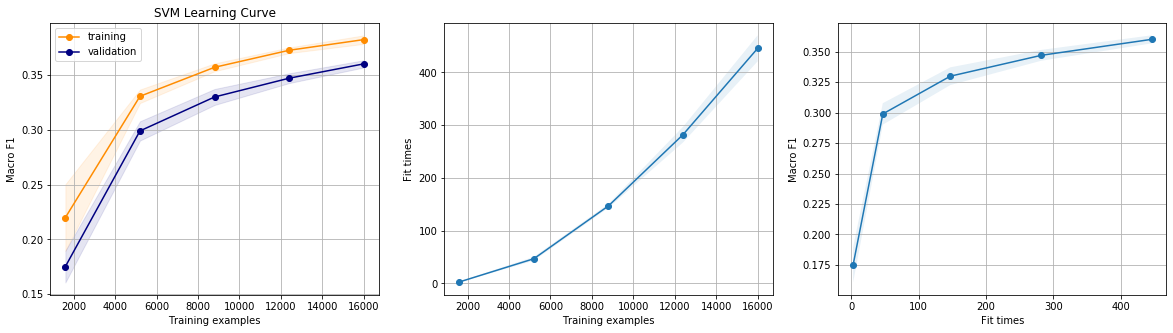

In [81]:
title = 'SVM Learning Curve'
utils.plot_learning_curve(svm_clf, title, scaled_x_train, y_train, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [82]:
svm_clf.fit(scaled_x_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [83]:
svm_pred = svm_clf.predict(scaled_x_test)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred, digits=4))

[[  4   0   1   0   1   1   2   0   1   0   4   0   1   0   0   0]
 [  0 106   0   2   0   2   3   0   3   0   7   0   0   1   0   0]
 [  0   0  17   0   0   0   6   1   1   1   1   0   1   5   2   0]
 [  0   0   0   1   0   0   0   1   0   0   1   0   1   0   0   0]
 [ 17  16  14  26 506  86  14 185  80  24  33   0  61  55 133  13]
 [ 17  26  14  11  50 121  21  21  51  10  17   3  18  41  12  17]
 [  7   9  16   3   2   4 173   6  20  12  13   2  15  17   4   1]
 [  9   0  10  27  46   4   2 269   8   7   4   0  11  12  25   6]
 [  6  33   2   2  14  31  15   7 101   5  20   3  11  14   3   3]
 [  2   6  18   4  10   7  23  30   6  51  16   0   5  12  10   4]
 [  2  11   3   2   0   5   5   1  10   3  24   0   1   3   7   0]
 [  0   2   0   0   0   1   0   0   3   0   0  96   0   0   0   0]
 [  6   1  29   5  19   8  17  24   7  19   9   3  36  36  13   5]
 [ 39   7  97   4  29  47  44  33  47  17  22   1  57 927  37  13]
 [  2   0   6   0   2   0   0   5   0   0   2   0   1   5   8 

# Boosting

In [85]:
base_tree_cf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', ccp_alpha=0.01, max_depth=7)

In [86]:
ada_clf = AdaBoostClassifier(base_estimator=base_tree_cf, random_state=5)
scores = cross_val_score(ada_clf, x_train, y_train, cv=5, n_jobs=8, scoring='f1_macro')
print(statistics.mean(scores))

0.2768084286300162


In [ ]:
param_range = [10, 100, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(
    ada_clf, x_train, y_train, param_name='n_estimators', param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "estimators")

In [9]:
param_range = [10, 100, 200, 300, 400, 500, 1000, 2000, 3000, 5000]
train_scores, test_scores = validation_curve(
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=1), 
        learning_rate=0.01
    ), x_train, y_train, param_name='n_estimators', param_range=param_range,
    scoring="f1_macro", verbose=10, n_jobs=8)
utils.plot_validation_curve(train_scores, test_scores, param_range, "Macro F1", "estimators")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  50 | elapsed:  1.1min remaining: 17.8min
[Parallel(n_jobs=8)]: Done   9 out of  50 | elapsed:  1.1min remaining:  5.2min
[Parallel(n_jobs=8)]: Done  15 out of  50 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=8)]: Done  21 out of  50 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=8)]: Done  27 out of  50 | elapsed:  1.1min remaining:   58.0s
[Parallel(n_jobs=8)]: Done  33 out of  50 | elapsed:  1.1min remaining:   35.1s
[Parallel(n_jobs=8)]: Done  39 out of  50 | elapsed:  1.1min remaining:   19.2s
[Parallel(n_jobs=8)]: Done  45 out of  50 | elapsed:  1.1min remaining:    7.6s


KeyboardInterrupt: 

In [11]:
params = [{'base_estimator': [
                DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=1)
            ],
           'n_estimators': [1000, 2000, 3000], 
           'learning_rate': np.geomspace(0.0001, 1.0, 10)}]
boost_grid_cv = GridSearchCV(AdaBoostClassifier(random_state=1), params, scoring='f1_macro', verbose=10, n_jobs=8, return_train_score=True)
boost_grid_cv.fit(x_train, y_train)
boost_res = boost_grid_cv.cv_results_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 40.2min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 119.7min


KeyboardInterrupt: 

In [54]:
boost_clf = boost_grid_cv.best_estimator_
print (boost_grid_cv.best_score_, boost_grid_cv.best_params_)

0.7832120286169867 {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}


In [6]:
boost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='entropy', max_depth=1),
                              n_estimators=2000, learning_rate=0.001)

[learning_curve] Training set sizes: [ 1600  5200  8800 12400 16000]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  25 | elapsed:  7.2min remaining: 82.9min
[Parallel(n_jobs=8)]: Done   5 out of  25 | elapsed: 31.9min remaining: 127.5min
[Parallel(n_jobs=8)]: Done   8 out of  25 | elapsed: 49.2min remaining: 104.6min
[Parallel(n_jobs=8)]: Done  11 out of  25 | elapsed: 67.6min remaining: 86.1min
[Parallel(n_jobs=8)]: Done  14 out of  25 | elapsed: 80.7min remaining: 63.4min
[Parallel(n_jobs=8)]: Done  17 out of  25 | elapsed: 102.9min remaining: 48.4min
[Parallel(n_jobs=8)]: Done  20 out of  25 | elapsed: 119.7min remaining: 29.9min
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed: 134.1min remaining: 11.7min
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed: 150.8min finished


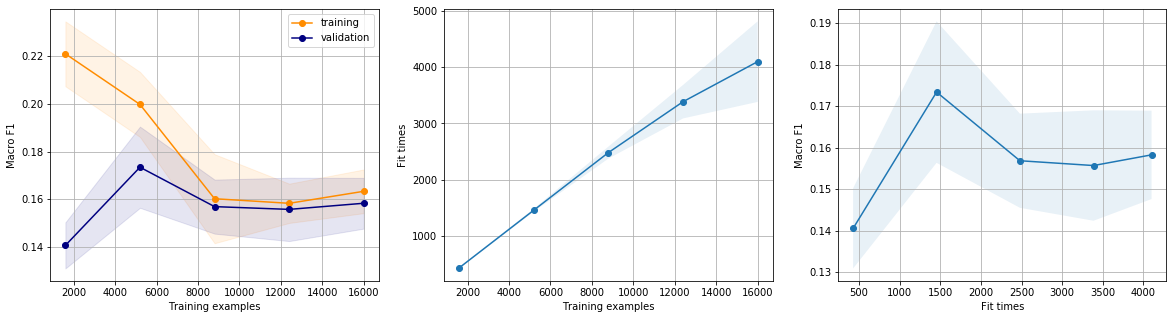

In [7]:
title = ''
utils.plot_learning_curve(boost_clf, title, x_train, y_train, scoring='f1_macro', loss=False, n_jobs=8)
plt.show()

In [ ]:
boost_clf.fit(x_test, y_test)

In [ ]:
boost_pred = boost_clf.predict(x_test)
print(confusion_matrix(y_test, boost_pred))
print(classification_report(y_test, boost_pred, digits=4))